# Spatial join and density

### Source: [Automating GIS-processes 2021](https://autogis-site.readthedocs.io/en/latest/lessons/L3/overview.html)

### The goal is to count the road intersections per postal code in Helsinki Region.

### 1- read the data

In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline 

In [6]:
# Filepaths
intersections_fp = "data/uusimaa_intersections.gpkg"
postcode_areas_fp = "data/uusimaa_postal_code_areas.gpkg"

intersections = gpd.read_file(intersections_fp)
postcode_areas = gpd.read_file(postcode_areas_fp)

In [7]:
intersections.head()

,x,y,geometry
0,330888.502,6675829.949,POINT (330888.502 6675829.949)
1,348059.990,6670041.685,POINT (348059.990 6670041.685)
2,348022.592,6670202.858,POINT (348022.592 6670202.858)
3,297208.220,6669048.357,POINT (297208.220 6669048.357)
4,330835.341,6675586.834,POINT (330835.341 6675586.834)


In [9]:
postcode_areas.head()

,posti_alue,he_vakiy,geometry
0,00100,18284.0,"MULTIPOLYGON (((385653.893 6671591.048, 385573..."
1,00120,7108.0,"MULTIPOLYGON (((385316.092 6671076.984, 385279..."
2,00130,1508.0,"MULTIPOLYGON (((386212.111 6671061.262, 386176..."
3,00140,7865.0,"MULTIPOLYGON (((386577.050 6670280.544, 386552..."
4,00150,9496.0,"MULTIPOLYGON (((384846.102 6669565.816, 384823..."


In [10]:
print(intersections.shape)
print(postcode_areas.shape)

(63518, 3)
(370, 3)


In [12]:
print(intersections.crs)
print(postcode_areas.crs)

epsg:3067
epsg:3067


## 2- plot the data

(6667500.0, 6680000.0)

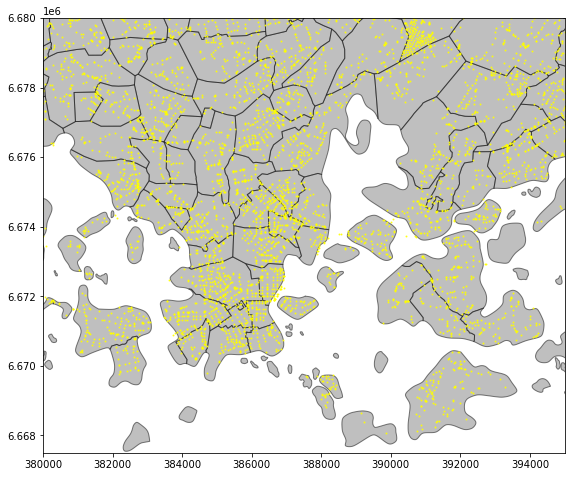

In [20]:
fig, ax = plt.subplots(figsize=(10,8))
postcode_areas.plot(ax=ax, color="gray", edgecolor="black", alpha= 0.5)
intersections.plot(ax=ax, color="yellow", markersize=1, alpha=0.8)

# Zoom to closer
ax.set_xlim([380000, 395000])
ax.set_ylim([6667500, 6680000])


## 3- spatial join

In [21]:
intersection_cnt= gpd.sjoin(postcode_areas, intersections)

In [24]:
intersection_cnt.head()

,posti_alue,he_vakiy,geometry,index_right,x,y
0,00100,18284.0,"MULTIPOLYGON (((385653.893 6671591.048, 385573...",42413,385612.662,6671729.650
0,00100,18284.0,"MULTIPOLYGON (((385653.893 6671591.048, 385573...",43086,385867.995,6671732.748
0,00100,18284.0,"MULTIPOLYGON (((385653.893 6671591.048, 385573...",43091,385855.918,6671756.492
0,00100,18284.0,"MULTIPOLYGON (((385653.893 6671591.048, 385573...",42414,385662.998,6671762.964
0,00100,18284.0,"MULTIPOLYGON (((385653.893 6671591.048, 385573...",51856,385383.080,6671704.067


In [25]:
intersection_cnt.shape

(63371, 6)

In [35]:
# Group the data by the posta code (posti_alue)
# size ()  counts the number of entries/rows 

intersection_cnt = intersection_cnt.groupby("posti_alue").size().reset_index()

In [40]:
# rename the column

intersection_cnt = intersection_cnt.rename(columns={0:"inter_count"})

In [41]:
intersection_cnt.head()

,posti_alue,inter_count
0,00100,203
1,00120,35
2,00130,50
3,00140,44
4,00150,68


In [42]:
# merge the data

postcode_areas = postcode_areas.merge(intersection_cnt, on="posti_alue")

In [43]:
postcode_areas.head()

,posti_alue,he_vakiy,geometry,inter_count
0,00100,18284.0,"MULTIPOLYGON (((385653.893 6671591.048, 385573...",203
1,00120,7108.0,"MULTIPOLYGON (((385316.092 6671076.984, 385279...",35
2,00130,1508.0,"MULTIPOLYGON (((386212.111 6671061.262, 386176...",50
3,00140,7865.0,"MULTIPOLYGON (((386577.050 6670280.544, 386552...",44
4,00150,9496.0,"MULTIPOLYGON (((384846.102 6669565.816, 384823...",68


## 4- Plot intersection density 
#### (The number of intersections per square kilometer inside a Postal code)

In [46]:
# check the unit of measurement
postcode_areas.crs

<Derived Projected CRS: EPSG:3067>
Name: ETRS89 / TM35FIN(E,N)
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Finland - onshore and offshore.
- bounds: (19.08, 58.84, 31.59, 70.09)
Coordinate Operation:
- name: TM35FIN
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [47]:
# create a new column for the area in km2

postcode_areas["area_km2"]= postcode_areas.area / 1000000

In [48]:
# create a new column for the density

postcode_areas["intersection_density"]= postcode_areas["inter_count"] / postcode_areas["area_km2"]

In [49]:
postcode_areas.head()

,posti_alue,he_vakiy,geometry,inter_count,area_km2,intersection_density
0,00100,18284.0,"MULTIPOLYGON (((385653.893 6671591.048, 385573...",203,2.353278,86.262634
1,00120,7108.0,"MULTIPOLYGON (((385316.092 6671076.984, 385279...",35,0.414010,84.539110
2,00130,1508.0,"MULTIPOLYGON (((386212.111 6671061.262, 386176...",50,0.428960,116.560895
3,00140,7865.0,"MULTIPOLYGON (((386577.050 6670280.544, 386552...",44,0.931841,47.218358
4,00150,9496.0,"MULTIPOLYGON (((384846.102 6669565.816, 384823...",68,1.367328,49.732046


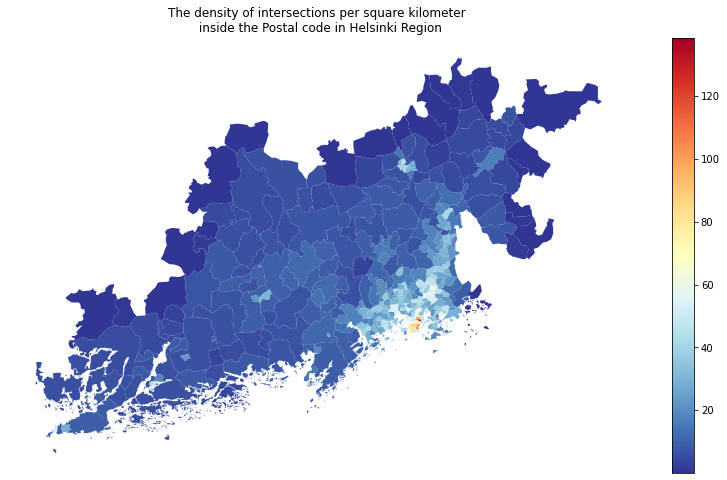

In [62]:
fig, ax = plt.subplots( figsize=(15, 8))

postcode_areas.plot(ax=ax, column= 'intersection_density', cmap='RdYlBu_r', legend=True,)

plt.title(f"The density of intersections per square kilometer \n inside the Postal code in Helsinki Region")
ax.axis('off')

outfp = r"static_maps/intersection_density.png"
plt.savefig(outfp, facecolor="white")

plt.show()
